# Basic Conception

## Amdahl's Law
Latency refers to the beginning-to-end duration of performing a single computation.

Thoughput refers to the number of computations that can be performed simultaneously. 

(high throughtput, high latency) GPU就像是很宽的城市道路，一次可以有很多个车道，但是所有车都很慢。
(low throughtput, low latency) CPU是很快的高速路，一次只允许几辆车，但是速度很快。


**Definition** (Amdahl's Law) The parallelizable proportion of execution time for code in original serial program is referred to as $p$ with the number of processor cores $N$. The speedup with Amdahl's Law is as follows:
$$
Speedup = \frac{1}{(1-p)+p/N}
$$

## The Mandelbrot set
**Definition** (Mandelbrot set) For a given complex number, $c$, we define a recursive sequence for $n\geq 0$, with $z_0=0$ and $z_n=z_{n-1}^2+c$ for $n\geq 0$. If $|z_n|$ remains bounded by 2 as $n$ increases to inifinity, then we will say that $c$ is a member of the Mandelbrot set. 

9.458302736282349s to calculate
0.04439210891723633s to dump


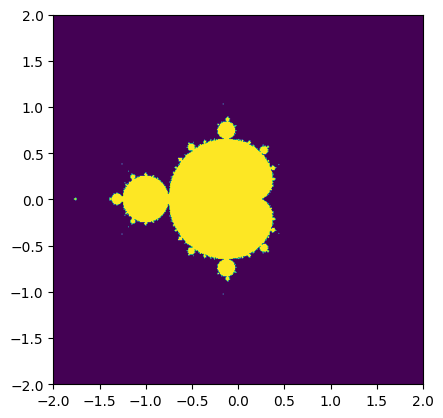

In [3]:
import numpy as np
from time import time 
# the following will prevent the figure from popping up
# matplotlib.use('Agg')
from matplotlib import pyplot as plt

def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters):
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)

    mandelbrot_graph = np.ones((height, width), dtype=np.float32)

    for x in range(width):
        for y in range(height):
            c = np.complex64(real_vals[x] + imag_vals[y] * 1j)
            z = np.complex64(0)

            for i in range(max_iters):
                z = z**2 +c

                if(np.abs(z)>2):
                    mandelbrot_graph[y,x] = 0
                    break
    
    return mandelbrot_graph



if __name__ == '__main__':
    t1=time()
    mandel=simple_mandelbrot(512,512,-2,2,-2,2,256)
    t2=time()
    mandel_time = t2- t1

    t1 = time()
    fig = plt.figure(1)
    plt.imshow(mandel, extent=(-2,2,-2,2))
    t2=time()

    dump_time=t2-t1

    print(f"{mandel_time}s to calculate")
    print(f"{dump_time}s to dump")

在计算这个代码的speedup前，我们需要得到本机的cuda core数量，安装完pycuda后，有

In [4]:
import pycuda.driver as cuda
import pycuda.autoinit

# 获取第一个 GPU 设备
device = cuda.Device(0)
print(f"Device name: {device.name()}")
print(f"Multiprocessors: {device.get_attribute(cuda.device_attribute.MULTIPROCESSOR_COUNT)}")

# 根据计算能力推断每个 SM 的核心数
cores_per_sm = {
    '3.0': 192,  # Kepler
    '3.5': 192,
    '5.0': 128,  # Maxwell
    '5.2': 128,
    '6.0': 64,   # Pascal
    '6.1': 128,
    '7.0': 64,   # Volta
    '7.5': 64,   # Turing
    '8.0': 128,  # Ampere
    '8.6': 128
}

sm = device.compute_capability()
sm_version = f"{sm[0]}.{sm[1]}"
total_cores = device.get_attribute(cuda.device_attribute.MULTIPROCESSOR_COUNT) * cores_per_sm.get(sm_version, 64)

print(f"Compute Capability: {sm_version}")
print(f"Total CUDA cores: {total_cores}")


Device name: NVIDIA TITAN RTX
Multiprocessors: 72
Compute Capability: 7.5
Total CUDA cores: 4608


回到之前的mandelbrot问题中，会发现在寻找c值时，这些c值是没有依赖关系的no interdependence的，二绘图的函数时不可以并行的。因此此时的$p=\frac{9.46}{9.46+0.04}=0.996$。我的服务器时有4608个cuda内核，因此理想speedup为$\frac{1}{0.01+.996/4608}$ 

## Profiling your code
To find the bottlenecks and hotspots, 我们使用称为 ’cProfile'来检查代码. This module is a standard library function that is contained in every modern python installation. 
We can run the profiler from the command line with '-m cProfile', and specify that we want to organize the results by the cumulative time spent on each function with '-s cumtime', and then redirect the output into a text file with '>' operator.

```bash
python -m cProfile -s cumtime mandelbrot0.py > manderlbrot_profile.txt
```
![](../figures/mandelbrot_profile.png)


